# Problem 4 - 1

3.2.4 Problem 4: Your Best Bidding Strategy (10/30 marks)
- Find a more optimal model
- The model you developed can be tested over the validation set.
- Explain your approach and discuss your results in the individual report. 
- This does include, but is not limited to, reporting the performance metrics of your solution + the parameter turning results on the validation set.
- Your bidding strategy described here may be part of the more complex model for the group, see problem 5 below, which will be tested over the test dataset.
- Some directions: A non-linear bidding strategy (e.g. ORTB) [2], a lift-based bidding [3] or using other CTR estimators.


## SETUP

In [1]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score,f1_score
sys.path.append("../Code/")
from utils import *
from sklearn import linear_model
from strategies import ortb_bidding_strategy

## DATA LOAD

In [2]:
# data directory
DATA_DIR = os.path.join('..', 'Data')

In [3]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [4]:
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

In [5]:
from scipy.sparse import csr_matrix
train_X_encoded = csr_matrix(train_X) 
valid_X_encoded = csr_matrix(valid_X)
test_X_encoded = csr_matrix(test_X)

In [6]:
print ("Train shape:", train_X_encoded.shape, "Valid shape:", valid_X_encoded.shape, "Test shape:", test_X_encoded.shape)

Train shape: (2430981, 824) Valid shape: (303925, 824) Test shape: (303375, 824)


for i in relevant_columns:
    print(i,len(set(train_X[i])))

## BUILD FIRST MODEL TO ESTIMATE CTR

price_model = xgboost.XGBRegressor(max_depth=10, n_estimators=100, random_state=0,
                        max_delta_step=1, objective='reg:linear', learning_rate=0.1, 
                        scale_pos_weight=1)

price_model.fit(train_X_encoded, np.log1p(train_y.payprice), eval_metric="rmse",  
          eval_set=[(valid_X_encoded, np.log1p(valid_y.payprice))],
          verbose=True, early_stopping_rounds=10)

### Training Model

In [8]:
#### IMPORT CTR PREDICTOR
import pickle
pkl_filename = "../lynray_logbest.pkl"  
with open(pkl_filename, 'rb') as file:  
    model = pickle.load(file)

In [9]:
bestC=0.01

model = linear_model.LogisticRegression(C=bestC,dual=False,max_iter=400,class_weight="balanced")
model.fit(train_X_encoded, train_y.click)

#print(xgb_model.score(train_X_encoded, train_y['click']))

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=400,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [9]:
valid_pred = model.predict_proba(valid_X_encoded)[:,1]

In [10]:
train_pred = model.predict_proba(train_X_encoded)[:,1]

### Logistic Regression

#### Base Bid Optimization

In [13]:
def base_bid_optimization(min_val, max_val, n, preds, true):

    base_bid = np.linspace(min_val, max_val, n)
    clicks = np.zeros_like(base_bid)

    for i, bb in zip(range(n), base_bid):
        bids = bb*preds
        _, c, _, _, _, _, _ = new_performance(bids, true, verbose=False)
        clicks[i] = c
    plt.plot(base_bid, clicks)
    plt.show()

    # best result
    print("Best number of clicks:", np.max(clicks))
    print("Best base bid:", base_bid[np.argmax(clicks)])
    return base_bid[np.argmax(clicks)]

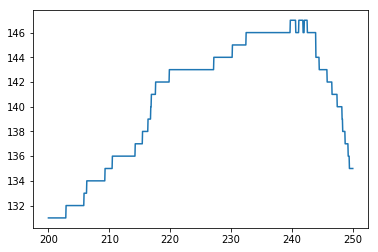

Best number of clicks: 147.0
Best base bid: 239.73973973973975


In [15]:
best_bb = base_bid_optimization(200, 250, 1000, valid_pred, valid_y)

In [49]:
best_bb

200.20020020020021

In [17]:
base = best_bb
bid_lin = valid_pred*base

In [18]:
_, c, _, _, _, _, _ = new_performance(bid_lin, valid_y)

               CTR: (0.1181)%
        num_clicks: 147
             spend: 6235011 (99.76)%
              aCPM: 20.51496586328864
              aCPC: 42.41504081632653
num_in_budget_wins: 124519
 ads_within_budget: 303925


### ORTB Strategy

In [72]:
lmda = 0.0208333
c_val = np.linspace(20, 300, 100)
clicks = np.zeros(shape=(c_val.shape[0]))

for i, cv in zip(range(100), c_val):
    bids = ortb_bidding_strategy(valid_pred*10, cv, lmda, 1)
    _, c, _, _, _, _, _ = new_performance(bids, valid_y, verbose=False)
    clicks[i] = c


In [38]:
6250/300000

0.020833333333333332

In [73]:
cvi = clicks.argmax()

In [43]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(valid_pred*100, 15.151516, 0.025253, 2)
new_performance(example_x, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.0685)%
        num_clicks: 108
             spend: 5952835 (95.25)%
              aCPM: 19.58652628115489
              aCPC: 55.11884259259259
num_in_budget_wins: 157774
 ads_within_budget: 303925


(0.06845234322511948,
 108,
 5952835,
 19.58652628115489,
 55.11884259259259,
 157774,
 303925)

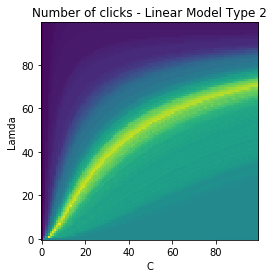

In [41]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Number of clicks - Linear Model Type 2")
ax.set_xlabel("C")
ax.set_ylabel("Lamda")
#plt.xticks
plt.imshow(c_2, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

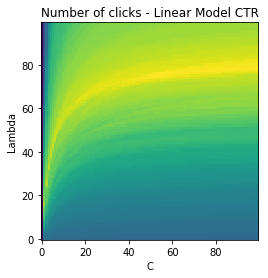

In [16]:
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 1, 1)
ax.set_title("Number of clicks - Linear Model CTR")
ax.set_xlabel("C")
ax.set_ylabel("Lambda")
#plt.xticks
plt.imshow(c_1, cmap='viridis', origin='lower')
plt.MaxNLocator(100)
plt.show()

In [17]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(valid_pred*10, 949.494950, 0.019697, 1)
new_performance(example_x, valid_y)

ORTB test:-
---------------------------------
               CTR: (0.1175)%
        num_clicks: 148
             spend: 6231877 (99.71)%
              aCPM: 20.504654108743935
              aCPC: 42.10727702702703
num_in_budget_wins: 125980
 ads_within_budget: 303925


(0.11747896491506589,
 148,
 6231877,
 20.504654108743935,
 42.10727702702703,
 125980,
 303925)

In [113]:
##### EXAMPLES OF ORTB BIDDING STRATEGY #####
print("ORTB test:-")
print("---------------------------------")
example_x = ortb_bidding_strategy(train_pred*100000, c_val[cvi], lmda[lmi], 2)
new_performance(example_x, train_y)

ORTB test:-
---------------------------------
               CTR: (0.1130)%
        num_clicks: 182
             spend: 6249935 (100.00)%
              aCPM: 20.6589616202
              aCPC: 34.3403021978
num_in_budget_wins: 161074
 ads_within_budget: 302529


(0.11299154425916037,
 182,
 6249935,
 20.658961620208309,
 34.340302197802202,
 161074,
 302529)

### Save Model

In [12]:
import pickle as pkl
pkl_filename = '../lynray_logbest.pkl'
with open(pkl_filename, 'wb') as file:  
    pkl.dump(model, file)

In [44]:
### Save Training Bids
train_bids = pd.DataFrame({"bidpriceORTB1": ortb_bidding_strategy(model.predict(train_X_encoded)*10, 949.494950, 0.019697, 1),
                                 "bidpriceORTB2": ortb_bidding_strategy(model.predict(train_X_encoded)*100,  15.151516, 0.025253, 2)
                                })

train_bids.to_csv('../train_bids_log.csv')

In [45]:
### Save Validation Bids
valid_bids = pd.DataFrame({"bidpriceORTB1": ortb_bidding_strategy(model.predict(valid_X_encoded)*10, 949.494950, 0.019697, 1),
                            "bidpriceORTB2": ortb_bidding_strategy(model.predict(valid_X_encoded)*100, 15.151516, 0.025253, 2)
                        })

valid_bids.to_csv('../valid_bids_log.csv')

In [46]:
### Save Test Bids
test_bids = pd.DataFrame({"bidpriceORTB1": ortb_bidding_strategy(model.predict(test_X_encoded)*10, 949.494950, 0.019697, 1),
                                 "bidpriceORTB2": ortb_bidding_strategy(model.predict(test_X_encoded)*100, 15.151516, 0.025253, 2)
                                })

test_bids.to_csv('../test_bids_log.csv')

In [ ]:
### Prepare Submission

In [ ]:
submission = pd.read_csv('../Data/Group_01.csv')

In [ ]:
submission.head()

In [ ]:
test_predictions = int(base_bid[np.argmax(clicks)])*CTR_model.predict(test_X)

In [ ]:
submission.bidprice = test_predictions

In [ ]:
submission.to_csv('../Group_01.csv')

### Extra

In [11]:
def join_table(data, newData, rowLen, colLen):
    for col in newData.keys():
        data = data.join(pd.DataFrame({col: [newData[col][r, c] for r in range(rowLen) for c in range(colLen)]}).reset_index(drop=True))
    return data

In [12]:
def analysis_table(pred, y, params, t, budget=6250*1000):
    start = time.time()
    lmda_range = params[0]
    c_val_range = params[1]
    clicks = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CTR = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    spend = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    CPM = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    eCPC = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    winrate_a = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    budget_lifetime = np.zeros(shape=(lmda.shape[0], c_val.shape[0]))
    
    params = {'lamda': [lmda_range[l] for l in range(len(lmda_range)) for _ in range(len(c_val_range))],
              'c' : [c_val_range[c] for _ in range(len(lmda_range)) for c in range(len(c_val_range))]}
    vals = pd.DataFrame(params).reset_index(drop=True)

    for i, lm in zip(range(len(lmda_range)), lmda_range):
        for j, cv in zip(range(len(c_val_range)), c_val_range):
            bids = ortb_bidding_strategy(pred, cv, lm, t)
            CTR[i,j], clicks[i, j], s, CPM[i, j], eCPC[i, j], wins, imps  = new_performance(bids, y, budget=budget, verbose=False)
            spend[i,j] = 100*s/budget
            winrate_a[i,j] = wins*100/imps
            budget_lifetime[i,j]= imps*100/len(y)
    cols = {'CTR': CTR,
            'clicks': clicks,
            'spend%': spend,
            'aCPM': CPM,
            'eCPC': eCPC,
            'win%': winrate_a,
            'lifetime%': budget_lifetime}
    vals = join_table(vals, cols, len(lmda_range), len(c_val_range)).reset_index(drop=True)

    print("time spent:- {0:.2f} seconds".format(time.time()-start))
    return vals, clicks

In [40]:
lmda = np.linspace(5e-7, 5e-2, 100)
c_val = np.linspace(5e-7, 100, 100)

In [41]:
a,c = analysis_table(valid_pred*10, valid_y, [lmda, c_val], 1)

time spent:- 714.80 seconds


In [44]:
a.sort_values(by='clicks', ascending=False).head()

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
2197,48.989899,0.010606,0.100800,137.0,99.781872,20.519427,45.520927,44.719256,100.000000
2198,49.494949,0.010606,0.100044,136.0,99.999184,20.612676,45.955507,44.833762,99.764416
2196,48.484848,0.010606,0.100313,136.0,99.337760,20.428099,45.651544,44.608045,100.000000
2195,47.979798,0.010606,0.100561,136.0,98.898512,20.337771,45.449684,44.498149,100.000000
2088,44.444444,0.010101,0.099621,136.0,99.999280,20.577677,45.955551,44.947897,99.934194


In [13]:
lmda = np.linspace(5e-7, 0.025, 100)
c_val = np.linspace(5e-7, 1000, 100)

In [14]:
a_1,c_1 = analysis_table(valid_pred*10, valid_y, [lmda, c_val], 1)

time spent:- 733.39 seconds


In [15]:
a_1.sort_values(by='clicks', ascending=False).head()

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
7894,949.494950,0.019697,0.117480,148.0,99.708624,20.504365,42.106682,41.450687,100.0
7895,959.595960,0.019697,0.117450,148.0,99.763440,20.515637,42.129831,41.461216,100.0
7775,757.575758,0.019445,0.117228,148.0,99.635280,20.489282,42.075709,41.539854,100.0
7774,747.474748,0.019445,0.117287,148.0,99.530112,20.467655,42.031297,41.518796,100.0
7772,727.272727,0.019445,0.117418,148.0,99.284912,20.417231,41.927750,41.472403,100.0


In [38]:
lmda = np.linspace(5e-7, 2.5, 100)
c_val = np.linspace(5e-7, 500, 100)

In [39]:
a_2,c_2 = analysis_table(valid_pred*100, valid_y, [lmda, c_val], 2)

time spent:- 1113.76 seconds


In [40]:
a_2.sort_values(by='clicks', ascending=False).head()

,c,lamda,CTR,clicks,spend%,aCPM,eCPC,win%,lifetime%
103,15.151516,0.025253,0.068452,108.0,95.245360,19.586526,55.118843,51.912149,100.000000
708,40.404041,0.176768,0.064853,106.0,99.258480,20.411796,58.525047,53.778728,100.000000
305,25.252526,0.075758,0.066282,105.0,94.538976,19.441263,56.273200,52.123057,100.000000
406,30.303031,0.101011,0.064602,105.0,99.999392,20.911625,59.523448,54.381598,98.338406
1513,65.656566,0.378788,0.063238,104.0,99.999088,20.588348,60.095606,54.175520,99.882208


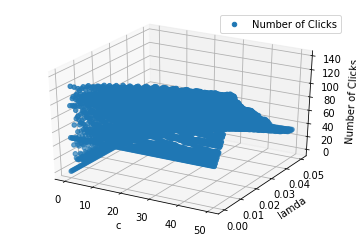

In [45]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
new_table = a[a['clicks'] > 0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a['c'], a['lamda'], a['clicks'], label='Number of Clicks')
ax.set_xlabel('c')
ax.set_ylabel('lamda')
ax.set_zlabel('Number of Clicks')
ax.legend()

plt.show()